# Clustering by Quantum Optimization 

We looked at one particular problem that you can solve by mapping it to an Ising model. This was a supervised problem, and it's very difficult to be competitive with supervised models on classical computers because that's exactly where deep learning excels at. An astounding point would be for quantum machine learning is that you can solve problems which remain hard in machine learning. So one of these is unsupervised learning. So deep learning and many other machine learning approaches have been making advances when it remains a difficult problem. So what happens here

$$\{x_{i}\}_{i=1}^{N}\qquad x_{i}\in\mathbb{R}^{d}$$

is that we are given a couple of points in some high dimensional space, but we do not get any prior information about whether they belong to a certain class or how they cluster in this structure. So for instance, we have to figure out what the labels would be and how we would assign those labels. 

$$P(y\mid x)\rightarrow\text{discriminative}$$

$$P(y\mid x)\rightarrow\text{generative}$$

This is a discriminative, unsupervised learning problem. And we can also ask the question what is the distribution of these points. Can we generate new points on this high dimensional manifold? That would be a generative problem. So let's look at clustering in this lecture. 

So in clustering, you have these high dimensional points, and you want to identify these clumps of points that somehow belong together. So if there's a nice separation, then a very simple learning algorithm called K means can identify these clusters. So in K means, you identify some center point of these locations. And then you assign clusters based on the proximity to this central point. This idea breaks down where the density matters. So for instance, in this case, K means clustering would assign these points to the green cluster, which is not correct. So what you could do instead, you can follow the density and assign points to the same cluster if they're connected in some topological way. And same thing for these green dots. So that's density-based clustering. So there are a couple of ways of doing it, and there's no clear winner. So here's one way of doing it by a quantum computer. We can think about calculating the gram matrix, the distance between every single point in the sample that we are given. So we fill this gram matrix

$$K_{ix}=d(x_{i},x_{j})$$

with the distances between individual points. This is a symmetric matrix because the distance function is symmetric. Now if you have the gram matrix, that actually defines a weighted graph. So the points of the graph will be the data instances. We can label them by the data instances. And the edges connecting them will be weighted by the corresponding distance between the points. And now we can ask, OK, so what's the highest value of a cut going through this graph. So we will now want to separate this graph in two a way that the value of this cut is maximal. So that would identify these two maximally separate clusters that we're actually looking for, looking at the overall global topology of the graph as opposed to some local heuristic. So we can do that. So say this part of the graph is called V1. So everything on this side of the cut is V1. And this is V2. Then the value of the cut is defined by the distances that cross the cut. So this will be a distance between all the points that line the two sides of the cut.

$$\sum_{i\in V_{1},j\in V_{2}}\underbrace{d(x_{i},x_{j})}_{w_{ij}}=\frac{1}{4}\sum w_{ij}+\sum w_{ij}\sigma_{i}\sigma_{j}$$ So I'm going to call this as a WIJ value. So we can expand the same thing in the following form. So imagine that you have values on the same side of the graph. So if-- now let's define a sigma i value as minus 1 if the corresponding xi point is in v1-- so on this side of the partition. And it's going to be plus 1 if the point is in v2. So if you have something on the same side and you calculate the product of this, as I did here, that's going to give you a plus 1. So that's going to cancel out in this equation. So it's actually not going to matter at all. So that looks good. So there's-- these two look equal in that sense. And if they belong to two separate sides, then they will have a negative value. So they will add. And it's a symmetric matrix. So right now you have to normalize with four. So this gives you the cost of the cut, and this is what you want to maximize. And now when you look at it, this is exactly an Ising model because here, you have your spin variables taking plus 1, minus 1 values. Here, you have the coupling strength, and you have some constant offset. And that's it. Now you can use Quantum Annealing, or QAOA, or any other quantum optimization subroutine that you have available and solve this problem. 

Check

• In an unsupervised learning problem... 

– Labels are not provided

• Calculating the Gram or kernel matrix $K_{ix}=d(x_{i},x_{j})$ ...

– Has $O(N^{2})$ computational complexity

• You are given a graph with strictly positive weights on its edges. A maximum cut...

– Takes exponentially many steps to find in the number of graph nodes.


Unsupervised learning means a lack of labels: we are looking for structure in the data, without having an *a priori* intuition what that structure might be. A great example is clustering, where the goal is to identify instances that clump together in some high-dimensional space. Unsupervised learning in general is a harder problem. Deep learning revolutionized supervised learning and it had made significant advances in unsupervised learning, but there remains plenty of room for improvement. In this notebook, we look at how we can map an unsupervised learning problem to graph optimization, which in turn we can solve on a quantum computer.

# Mapping clustering to discrete optimization

Assume that we have some points $\{x_i\}_{i=1}^N$ lying in some high-dimensional space $\mathbb{R}^d$. How do we tell which ones are close to one another and which ones are distant? To get some intuition, let's generate a simple dataset with two distinct classes. The first five instances will belong to class 1, and the second five to class 2:

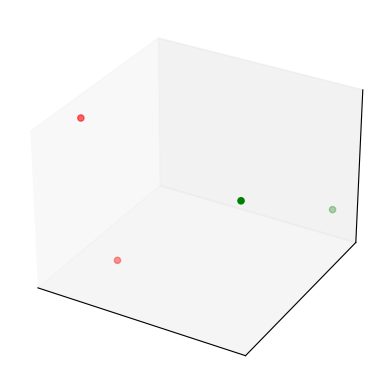

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

n_instances = 4
class_1 = np.random.rand(n_instances//2, 3)/5
class_2 = (0.6, 0.1, 0.05) + np.random.rand(n_instances//2, 3)/5
data = np.concatenate((class_1, class_2))
colors = ["red"] * (n_instances//2) + ["green"] * (n_instances//2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', xticks=[], yticks=[], zticks=[])
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors)

The high-dimensional space is endowed with some measure of distance, the Euclidean distance being the simplest case. We can calculate all pairwise distances between the data points:

In [2]:
import itertools
w = np.zeros((n_instances, n_instances))
for i, j in itertools.product(*[range(n_instances)]*2):
    w[i, j] = np.linalg.norm(data[i]-data[j])

This matrix is sometimes called the Gram or the kernel matrix. The Gram matrix contains a fair bit of information about the topology of the points in the high-dimensional space, but it is not easy to see. We can think of the Gram matrix as the weighted adjacency matrix of a graph: two nodes represent two data instances. Their distance as contained in the Gram matrix is the weight on the edge that connects them. If the distance is zero, they are not connected by an edge. In general, this is a dense graph with many edges -- sparsity can be improved by a distance function that gets exponentially smaller.

What can we do with this graph to find the clusters? We could look for the max-cut, that is, the collection of edges that would split the graph in exactly two if removed, while maximizing the total weight of these edges [[1](#1)]. This is a well-known NP-hard problem, but it also very naturally maps to an Ising model.

The spin variables $\sigma_i \in \{-1, +1\}$ take on value $\sigma_i = +1$ if a data instance is in cluster 1 (nodes $V_1$ in the graph), and $\sigma_i = -1$ if the data instance is in cluster 2 (nodes $V_2$ in the graph). The cost of a cut is

$$
\sum_{i\in V_1, j\in V_2} w_{ij}
$$

Let us assume a fully connected graph. Then, accounting for the symmetry of the adjacency matrix, we can expand this as
$$
\frac{1}{4}\sum_{i, j} w_{ij} - \frac{1}{4} \sum_{i, j} w_{ij} \sigma_i \sigma_j
$$
$$
= \frac{1}{4}\sum_{i, j\in V} w_{ij} (1- \sigma_i \sigma_j).
$$                 

By taking the negative of this, we can directly solve the problem by a quantum optimizer.

# Solving the max-cut problem by QAOA

Most quantum computing frameworks have convenience functions defined for common graph optimization algorithms, and max-cut is a staple. This reduces our task to importing the relevant functions:

In [3]:
from qiskit.aqua import get_aer_backend, QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.translators.ising import max_cut

ModuleNotFoundError: No module named 'qiskit.aqua'

Setting $p=1$ in the QAOA algorithm, we can initialize it with the max-cut problem.

In [ ]:
qubit_operators, offset = max_cut.get_max_cut_qubitops(w)
p = 1
optimizer = COBYLA()
qaoa = QAOA(qubit_operators, optimizer, p, operator_mode='matrix')

Here the choice of the classical optimizer `COBYLA` was arbitrary. Let us run this and analyze the solution. This can take a while on a classical simulator.

In [ ]:
backend = get_aer_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=1)
result = qaoa.run(quantum_instance)
x = max_cut.sample_most_likely(result['eigvecs'][0])
graph_solution = max_cut.get_graph_solution(x)
print('energy:', result['energy'])
print('maxcut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

energy: -0.8076121640957552
maxcut objective: -2.3045777105109226
solution: [0. 0. 1. 1.]
solution objective: 2.6693304526211796


Looking at the solution, the cut matches the clustering structure.

# Solving the max-cut problem by annealing

Naturally, the same problem can be solved on an annealer. Our only task is to translate the couplings and the on-site fields to match the programming interface:

In [ ]:
import dimod

J, h = {}, {}
for i in range(n_instances):
    h[i] = 0
    for j in range(i+1, n_instances):
        J[(i, j)] = w[i, j]

model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=10)
print("Energy of samples:")
for solution in response.data():
    print("Energy:", solution.energy, "Sample:", solution.sample)

Energy of samples:
Energy: -2.344729812412025 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.344729812412025 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.344729812412025 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.344729812412025 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.344729812412025 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.344729812412025 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.344729812412025 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.344729812412025 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.344729812412025 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.344729812412025 Sample: {0: 1, 1: 1, 2: -1, 3: -1}


If you look at the first sample, you will see that the first five data instances belong to the same graph partition, matching the actual cluster.

# References

[1] Otterbach, J. S., Manenti, R., Alidoust, N., Bestwick, A., Block, M., Bloom, B., Caldwell, S., Didier, N., Fried, E. Schuyler, Hong, S., Karalekas, P., Osborn, C. B., Papageorge, A., Peterson, E. C., Prawiroatmodjo, G., Rubin, N., Ryan, Colm A., Scarabelli, D., Scheer, M., Sete, E. A., Sivarajah, P., Smith, Robert S., Staley, A., Tezak, N., Zeng, W. J., Hudson, A., Johnson, Blake R., Reagor, M., Silva, M. P. da, Rigetti, C. (2017). [Unsupervised Machine Learning on a Hybrid Quantum Computer](https://arxiv.org/abs/1712.05771). *arXiv:1712.05771*. <a id='1'></a>